In [14]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Sequential

from tensorflow.strings import regex_replace
from tensorflow.keras.preprocessing import text_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import json
import os
import shutil
import zipfile
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
numGPUs = len(tf.config.experimental.list_physical_devices('GPU'))
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.python.client import device_lib
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
print('Num GPUs Available: ', numGPUs)

if numGPUs > 0:
    print(tf.test.gpu_device_name())
    print(device_lib.list_local_devices()[1].physical_device_desc)


Num GPUs Available:  0


2022-12-08 00:03:01.337122: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/nate/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [15]:
stars = {"stars": int} 

jsonFile = pd.read_json(
"/home/nate/neuralNets/NeuralNet/Homework/hw5/yelp_academic_dataset_review.json",
lines=True,
chunksize=10000,
dtype=stars,
orient='records'

)




In [16]:
checkin_df=[]
for x, section in enumerate(jsonFile):
    sec=section.drop(columns=['review_id', 'user_id', 'business_id', 'date', 'useful', 'funny', 'cool'])
    sec['text']=sec['text'].str.lower()
    sec['text']=sec['text'].str.replace(r'[^\w\s]','',regex=True)
    checkin_df.append(sec)
    if(x>1):
        break

In [17]:
df = pd.concat(checkin_df, ignore_index=True)
df['text'] = df['text'].str.split()
display(df)

,stars,text
0,3,"[if, you, decide, to, eat, here, just, be, awa..."
1,5,"[ive, taken, a, lot, of, spin, classes, over, ..."
2,3,"[family, diner, had, the, buffet, eclectic, as..."
3,5,"[wow, yummy, different, delicious, our, favori..."
4,4,"[cute, interior, and, owner, gave, us, tour, o..."
...,...,...
29995,5,"[the, best, sandwich, in, the, renosparks, are..."
29996,4,"[great, service, very, friendly, and, they, do..."
29997,4,"[i, can, customize, my, rolls, yay, im, pregna..."
29998,1,"[this, is, the, biggest, joke, of, a, club, of..."


In [18]:
def tokenize(contents):
    text_tokens = tf.keras.preprocessing.text.Tokenizer(num_words=8000)
    text_tokens.fit_on_texts(contents)
    tensor = text_tokens.texts_to_sequences(contents)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,padding='post')
    return tensor, text_tokens

allX,token = tokenize(df["text"])
allY=df["stars"].to_numpy()

In [19]:
print(len(allX), '\n',allX)
print(type(allX))
print(allX.shape, allY.shape)


30000 
 [[  38   20 1397 ...    0    0    0]
 [  88  765    3 ...    0    0    0]
 [ 288 1170   21 ...    0    0    0]
 ...
 [   4   70 4020 ...    0    0    0]
 [  17    8    1 ...    0    0    0]
 [5120  121    3 ...    0    0    0]]
<class 'numpy.ndarray'>
(30000, 985) (30000,)


In [20]:
from sklearn.model_selection import train_test_split

trainX, testValx, trainY, testValy = train_test_split(allX, allY, test_size=0.4, random_state=42)
valX, testX, valY, testY = train_test_split(testValx, testValy, test_size=0.5, random_state=42)


In [21]:
BUFFER_SIZE_TRAIN = len(trainX)
BUFFER_SIZE_TEST = len(testX)
BATCH_SIZE_TRAIN = 512
BATCH_SIZE_TEST = 512

steps_per_epoch_train = len(trainX)//BATCH_SIZE_TRAIN
steps_per_epoch_test = len(testX)//BATCH_SIZE_TEST

embedding_dim = 256
units = 1024
vocab_inp_size = len(token.word_index)+1

train_dataset = tf.data.Dataset.from_tensor_slices((trainX,trainY)).shuffle(BUFFER_SIZE_TRAIN)
train_dataset = train_dataset.batch(BATCH_SIZE_TRAIN, drop_remainder=True)

test_dataset = tf.data.Dataset.from_tensor_slices((testX,testY)).shuffle(BUFFER_SIZE_TEST)
test_dataset = test_dataset.batch(BATCH_SIZE_TEST,drop_remainder=True)

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(token.word_index)+1,200,trainable=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(256,dropout=0.5,return_sequences=True)),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(256,dropout=0.5,return_sequences=True)),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation='linear'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6,activation='softmax')
    
])

In [23]:
# model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               optimizer=tf.keras.optimizers.Adam(0.00225),
#               metrics=['accuracy'])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 200)         10330000  
                                                                 
 dropout_2 (Dropout)         (None, None, 200)         0         
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 512)        233984    
 nal)                                                            
                                                                 
 layer_normalization_2 (Laye  (None, None, 512)        1024      
 rNormalization)                                                 
                                                                 
 bidirectional_3 (Bidirectio  (None, None, 512)        393728    
 nal)                                                            
                                                      

In [24]:
print(np.__version__, '\n', tf.__version__)

1.23.5 
 2.11.0


Epoch 1/5
563/563 [==============================] - 4497s 8s/step - loss: 0.3880 - accuracy: 0.4253 - val_loss: 0.3748 - val_accuracy: 0.4410
Epoch 2/5
563/563 [==============================] - 967s 2s/step - loss: 0.3767 - accuracy: 0.4416 - val_loss: 0.3718 - val_accuracy: 0.4410
Epoch 3/5
563/563 [==============================] - 950s 2s/step - loss: 0.3748 - accuracy: 0.4428 - val_loss: 0.3732 - val_accuracy: 0.4410
Epoch 4/5
563/563 [==============================] - 950s 2s/step - loss: 0.3728 - accuracy: 0.4428 - val_loss: 0.3694 - val_accuracy: 0.4420
Epoch 5/5
563/563 [==============================] - 23824s 42s/step - loss: 0.3802 - accuracy: 0.4391 - val_loss: 0.3804 - val_accuracy: 0.4410


ValueError: x and y must have same first dimension, but have shapes (10,) and (5,)

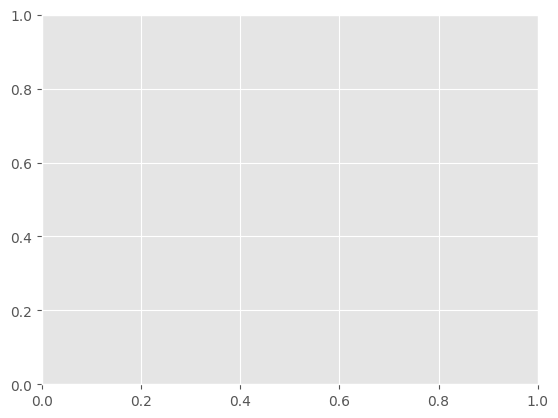

In [25]:
epochs = 5

trainY= tf.keras.utils.to_categorical(trainY)
valY= tf.keras.utils.to_categorical(valY)

data2=df['text'].tail(5)
H = model.fit(trainX, trainY, validation_data = (valX,valY), epochs = epochs)

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), H.history['accuracy'], label = 'train_acc')
plt.plot(np.arange(0, epochs), H.history['val_accuracy'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()


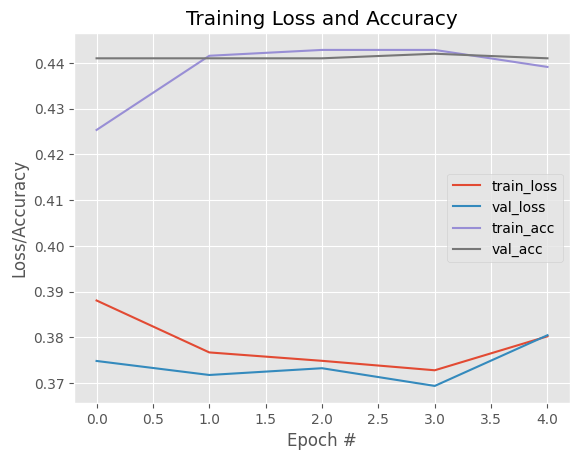

In [27]:
epochs=5
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), H.history['accuracy'], label = 'train_acc')
plt.plot(np.arange(0, epochs), H.history['val_accuracy'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 30000, 985, 128)   1024128   
                                                                 
 dense_18 (Dense)            (None, 30000, 985, 64)    8256      
                                                                 
 dense_19 (Dense)            (None, 30000, 985, 64)    4160      
                                                                 
 dense_20 (Dense)            (None, 30000, 985, 1)     65        
                                                                 
Total params: 1,036,609
Trainable params: 1,036,609
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5


ValueError: in user code:

    File "/home/nate/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/home/nate/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/nate/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/home/nate/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "/home/nate/anaconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/nate/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_7" is incompatible with the layer: expected shape=(None, 30000, 985), found shape=(None, 985)


: 

: 

[[ 81  33 223 ...   0   0   0]
 [ 89 243   4 ...   0   0   0]
 [289 127  16 ...   0   0   0]
 ...
 [  1 622   2 ...   0   0   0]
 [  5  35   3 ...   0   0   0]
 [ 13 662  68 ...   0   0   0]]
